In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=ef7016b467fb7f1fae39a4c08a232e897c5dd063ff8104dda085a8a54e9e1db0
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [50]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, time, cv2, imutils
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imutils.video import VideoStream
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [3]:
train_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/"
valid_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/"
test_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/"

In [4]:
def import_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [5]:
X_train, y_train = import_images(train_dir)
X_val, y_val = import_images(valid_dir)
X_test, y_test = import_images(test_dir)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

In [6]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [7]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [9]:
# Initializing CNN layer
cnn = Sequential()

# 1st Convolutional Layer
cnn.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Layer
cnn.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())

# 3rd Convolutional Layer
cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

# 4th Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Flattening
cnn.add(Flatten())

# Fully-connected Layer
cnn.add(Dense(units=128,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# Output Layer
cnn.add(Dense(units=2,activation='sigmoid'))

2022-08-17 11:07:00.747417: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0

In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=15,verbose=1,restore_best_weights=True,mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,factor=0.1,min_lr=0.001,verbose=1,mode='max')
checkpoint_filename = "checkpoint/"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,mode='max',save_best_only=True,save_weights_only=True)

r = cnn.fit(x=X_train,
            y=y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_val,y_val),
            callbacks=[early_stopping,reduce_lr,model_checkpoint]
            )

2022-08-17 11:07:03.389345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
313/313 [==============================] - 147s 466ms/step - loss: 0.0760 - accuracy: 0.9734 - val_loss: 0.1702 - val_accuracy: 0.9588

Epoch 00001: val_accuracy improved from -inf to 0.95875, saving model to checkpoint/
Epoch 2/25
313/313 [==============================] - 145s 462ms/step - loss: 0.0362 - accuracy: 0.9876 - val_loss: 0.0420 - val_accuracy: 0.9837

Epoch 00002: val_accuracy improved from 0.95875 to 0.98375, saving model to checkpoint/
Epoch 3/25
313/313 [==============================] - 146s 466ms/step - loss: 0.0296 - accuracy: 0.9901 - val_loss: 0.0227 - val_accuracy: 0.9900

Epoch 00003: val_accuracy improved from 0.98375 to 0.99000, saving model to checkpoint/
Epoch 4/25
313/313 [==============================] - 144s 462ms/step - loss: 0.0294 - accuracy: 0.9899 - val_loss: 0.0261 - val_accuracy: 0.9925

Epoch 00004: val_accuracy improved from 0.99000 to 0.99250, saving model to checkpoint/
Epoch 5/25
313/313 [==============================] - 147s 469m

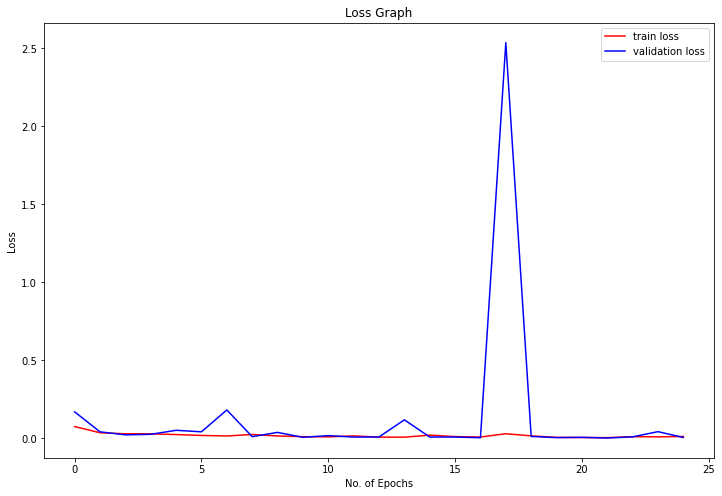

In [13]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend();

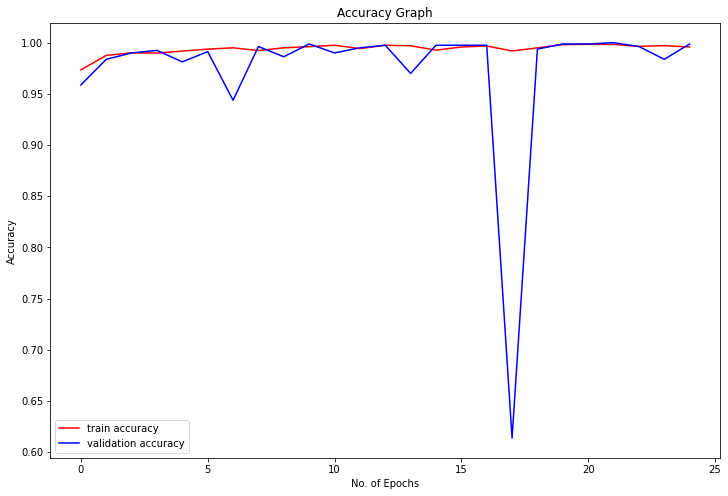

In [14]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend();

In [15]:
cnn.load_weights(checkpoint_filename)

In [28]:
test_pred = cnn.predict(X_test)
test_pred

array([[1.2410881e-05, 9.9998868e-01],
       [1.8634990e-05, 9.9998790e-01],
       [6.7551737e-06, 9.9999452e-01],
       ...,
       [9.9998713e-01, 9.5622936e-06],
       [1.0000000e+00, 3.8661547e-08],
       [9.9997044e-01, 3.4655608e-05]], dtype=float32)

In [39]:
loss, acc = cnn.evaluate(X_test,y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

31/31 [==============================] - 4s 136ms/step - loss: 0.0123 - accuracy: 0.9970
Test Loss: 0.012268483638763428
Test Accuracy: 0.9969757795333862


In [51]:
cnn.save('face_mask_detector.h5')
model = load_model('face_mask_detector.h5')
model